In [1]:
import sys
import joblib
import os
import scipy.io as sio
import numpy as np

from scipy.ndimage import binary_erosion
from scipy.spatial.distance import cdist
from scipy.interpolate import interp1d

from geopy.distance import geodesic

import cmocean

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import geopandas as gpd
import pandas as pd

In [2]:
# Adjust the path to your project root directory where 'models' folder is located
project_root = os.path.abspath('../../../')  # or the relative path to your root from the notebook folder

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.models.cnn import CNN_AE
from src.models.pca import PCA_AE
from src.inputs import GaussianInputs
from src.optimizer import GPOptimizer, DeepGPOptimizer
from src.utils import *

In [3]:
project = 'fvcom'

In [4]:
states = gpd.read_file(f'{project_root}/data/massachusetts/s_08mr23.shp')
mass = states[states['NAME']=='Massachusetts']
xmin = -71.25+0.05
xmax = -69.75-0.05
ymin = 41.6+0.05
ymax = 42.8-0.05

In [5]:
t = np.load(f'{project_root}/data/{project}/t.npy')
reference_date = pd.Timestamp("2005-01-01")
datetimes = [reference_date + pd.to_timedelta(days - 732313.0, unit='D') for days in t]
datetimes_np = np.array(datetimes, dtype='datetime64[ns]')


# Find tstep where datetimes_np is July 9th, 2011
start_time = pd.Timestamp('2010-07-08T00:00:00Z')
start_time = pd.Timestamp('2010-07-09T00:00:00Z')
start_time_np = np.datetime64(start_time)
tstep = np.argmin(np.abs(datetimes_np - start_time_np))


date_print = start_time.strftime('%Y-%m-%d')
date_save = start_time.strftime('%Y-%m-%d-%H')+'h'
print(date_print)
print(datetimes_np[tstep])
print(tstep)

2010-07-09
['2010-07-08T22:01:52.500000000']
9616


In [6]:
drifters_xlsx = pd.read_excel(f'{project_root}/data/student_drifter_program/SDP-2008-2017.xlsx', header=None)

In [7]:
drifters = drifters_xlsx.iloc[:, 1:]
drifters.columns = ['ID', 'Latitude', 'Longitude', 'Type', 'Timestamp', 'Start Depth', 'End Depth']
drifters['date'] = pd.to_datetime(drifters['Timestamp'])
drifters['Year'] = drifters.groupby('ID')['date'].transform('min').dt.year
drifters['ID'] = drifters['ID'].astype('int')
drifters = drifters[drifters['ID'] != 106410706]

drifters = drifters.drop_duplicates()

drifters = drifters[(drifters['Year'] == 2010) | (drifters['Year'] == 2005)]

drifters = drifters[(drifters['Longitude'] >= xmin) & (drifters['Longitude'] <= xmax) & 
                    (drifters['Latitude'] >= ymin) & (drifters['Latitude'] <= ymax)]


most_active_days = drifters.groupby(drifters['date'].dt.floor('D'))['ID'].nunique().sort_values(ascending=False)
drifters = drifters[drifters['date'].dt.floor('D').isin(most_active_days.index[:30])]

print(len(drifters))

drifters = drifters.groupby('ID').filter(lambda group: len(group) > 30)
print(len(drifters))

drifters.head()

3252
3034


,ID,Latitude,Longitude,Type,Timestamp,Start Depth,End Depth,date,Year
78558,1064107010,41.9495,-70.4973,Kara,2010-06-25T13:47:00Z,10.0,16.0,2010-06-25 13:47:00+00:00,2010
78560,1064107010,41.9419,-70.4873,Kara,2010-06-25T14:48:00Z,10.0,16.0,2010-06-25 14:48:00+00:00,2010
78562,1064107010,41.9348,-70.4776,Kara,2010-06-25T15:48:00Z,10.0,16.0,2010-06-25 15:48:00+00:00,2010
78564,1064107010,41.9285,-70.4736,Kara,2010-06-25T16:52:00Z,10.0,16.0,2010-06-25 16:52:00+00:00,2010
78566,1064107010,41.9224,-70.4733,Kara,2010-06-25T17:47:00Z,10.0,16.0,2010-06-25 17:47:00+00:00,2010


[106420703 106420704 107420702]
3


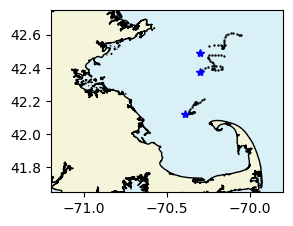

In [8]:
ndays = 4/3
end_time = start_time + pd.Timedelta(days=ndays)
subset = drifters[(drifters['date'] >= start_time) & (drifters['date'] <= end_time)].copy().sort_values('date').reset_index(drop=True)

# Only keep drifters that have traveled at least min_distance_km (e.g., 5 km)
min_distance_km = 10

def traj_distance_km(traj):
    # traj: Nx2 array of [lon, lat]
    return np.sum([geodesic(traj[i], traj[i+1]).km for i in range(len(traj)-1)])

# Compute distance for each drifter
drifter_distances = subset.groupby('ID').apply(lambda df: traj_distance_km(df[['Longitude', 'Latitude']].values))
longest_ids = drifter_distances[drifter_distances >= min_distance_km].index
subset = subset[subset['ID'].isin(longest_ids)].reset_index(drop=True)
print(subset['ID'].unique())


trajectories = {}
trajectories_m = {}
dts = []

for idx, drifter_id in enumerate(subset['ID'].unique()):
    drifter_data = subset[subset['ID'] == drifter_id].sort_values('date').reset_index(drop=True)
    traj = drifter_data[['Longitude', 'Latitude']].to_numpy()
    # time differences in seconds
    dt = drifter_data['date'].diff().dt.total_seconds().iloc[1:].fillna(0).tolist()
    traj_m = np.array(sp_proj('forward', traj[:,0], traj[:,1], 'm')).T

    trajectories[idx] = traj
    trajectories_m[idx] = traj_m
    dts.append(dt)

num_traj = len(trajectories)
print(len(dts))

fig, ax = plt.subplots(figsize=(3,3))
ax.set_facecolor(np.array([218, 240, 247])/255)
plot_trajectories_lines(trajectories)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
mass.plot(ax=ax, color='beige', edgecolor='black')
ax.set_aspect('equal')

In [9]:
xmin = -71.25+0.05
xmax = -69.75-0.05
ymin = 41.6+0.05
ymax = 42.8-0.05

grid_x = np.load(f'{project_root}/data/{project}/grid_x.npy')
grid_y = np.load(f'{project_root}/data/{project}/grid_y.npy')
grid_x_m, grid_y_m = sp_proj('forward', grid_x, grid_y,  'm')

u = np.load(f'{project_root}/data/{project}/u_interp.npy') 
v = np.load(f'{project_root}/data/{project}/v_interp.npy')
nt, n1, n2 = u.shape
mask = np.isnan(u[0,:,:])

u_fill, v_fill = u.copy(), v.copy()
u_fill[:, mask] = 0
v_fill[:, mask] = 0

In [10]:
latent_dim = 30
data, ae_scaler = transform_data_for_AE(u,v)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
ae = CNN_AE(latent_dim=latent_dim)
ae.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_model.pth'))
ae.to(device)
latent_space = get_latent_space(ae, data)

# device = 'cpu'
# ae = PCA_AE.load(f'{project_root}/src/models/checkpoints/{project}/pca_{latent_dim}_model.pkl')
# latent_space = ae.encode(data).T

D = ae.decode

latent_distribution = gaussian_kde(latent_space)

 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning:Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1719512383855/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)


In [11]:
acquisition_function = 'LCB'
optimizer = DeepGPOptimizer(trajectories_m, dts, trajectory_cost_function, D, latent_distribution, grid_x_m, grid_y_m, ae_scaler, device, acquisition_function, mask)
# optimizer = GPOptimizer(trajectories_m, dts, trajectory_cost_function, D, latent_distribution, grid_x_m, grid_y_m, ae_scaler, device, acquisition_function, mask)

In [12]:
try:
    optimizer.optimize(n_iterations=150)
except Exception as e:
    print(f"Optimization failed with error: {e}")

Iteration 0: 341707.28187069163
Iteration 2: 209941.37859027355
Iteration 26: 194754.5342504496
Iteration 127: 158509.3748205633


In [13]:
optimizer.optimize(n_iterations=50)

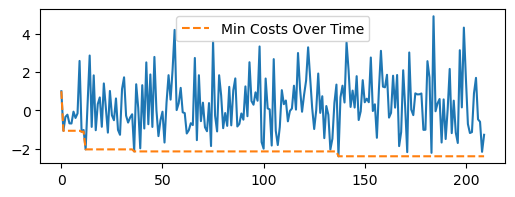

In [14]:
costs = optimizer.Y
min_costs_over_time = [np.min(costs[:i+1]) for i in range(len(costs))]
plt.figure(figsize=(6,2))
plt.plot(costs)
plt.plot(min_costs_over_time, label='Min Costs Over Time', linestyle='--')
plt.legend()

In [15]:
z_opt, u_opt, v_opt, traj_opt_m = optimizer.get_optimal()

traj_opt = {}
for traj_i in range(num_traj):
    traj_opt[traj_i] = np.array(sp_proj('inverse', traj_opt_m[traj_i][:,0], traj_opt_m[traj_i][:,1], 'm')).T


In [ ]:
w_opt = vort_FVCOM(u_opt, v_opt, grid_x_m, grid_y_m)
psi_opt = streamfunction_FVCOM(w_opt, grid_x_m, grid_y_m)

costs = optimizer.Y
costs = optimizer.scaler_gp_y.inverse_transform(costs.reshape(-1, 1)).reshape(-1)
costs_sorted = np.sort(costs)

k=3
z_top, u_top, v_top, traj_top_m = optimizer.get_top_k(k)
traj_top = []
for traj_k in range(k):
    traj_top.append({})
    for traj_i in range(num_traj):
        traj_top[traj_k][traj_i] = np.array(sp_proj('inverse', traj_top_m[traj_k][traj_i][:,0], traj_top_m[traj_k][traj_i][:,1], 'm')).T

w_top = np.array([vort_FVCOM(ui, vi, grid_x_m, grid_y_m) for ui, vi in zip(u_top, v_top)])
psi_top = np.array([streamfunction_FVCOM(wi, grid_x_m, grid_y_m) for wi in w_top])

u_mean = np.mean(np.array(u_top), axis=0)
v_mean = np.mean(np.array(v_top), axis=0)
w_mean = np.mean(np.array(w_top), axis=0)
psi_mean = np.mean(np.array(psi_top), axis=0)

w_opt = w_opt*1e5
w_mean = w_mean*1e5
w_top = w_top*1e5

use_km = False
if use_km:
    psi_opt = psi_opt/1e6
    psi_mean = psi_mean/1e6
    psi_top = psi_top/1e6
    units = 'km$^2$/s'
else:
    units = 'm$^2$/s'

In [17]:
vmin_u, vmax_u = -0.25, 0.25
vmin_v, vmax_v = -0.6, 0.6
vmin_psi, vmax_psi = np.nanmin(psi_opt), np.nanmax(psi_opt)
psi_err_lim = 0.5*np.max(np.abs([vmin_psi, vmax_psi]))

vmin_vort, vmax_vort = 0.1*np.nanmin(w_opt), 0.1*np.nanmax(w_opt)
vort_err_lim = 0.7*np.max(np.abs([vmin_vort, vmax_vort]))

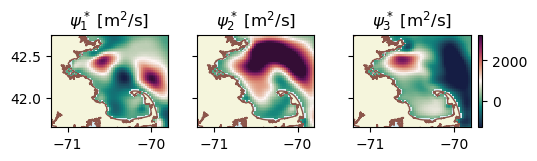

In [18]:
fig, axes = plt.subplots(1, k, figsize=(1.75* k, 1.5), sharex=True, sharey=True, constrained_layout=True)

for idx in range(k):
    ax = axes[idx] if k > 1 else axes
    ax.set_facecolor(np.array([218, 240, 247])/255)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    mass.plot(ax=ax, color='beige', edgecolor='tab:brown')
    ax.set_aspect('equal', adjustable='box')
    c = ax.pcolormesh(grid_x, grid_y, psi_top[idx], cmap=cmocean.cm.curl, vmin=vmin_psi, vmax=vmax_psi)
    ax.set_title(f'$\psi^*_{idx+1}$ [' + units + ']')
    if idx == k-1:
        plt.colorbar(c, ax=ax)

# plt.savefig(f'{project_root}/figures/{project}/bo/top{k}_psi_{latent_dim}_idx_{date_save}_real.png', dpi=300, bbox_inches='tight')


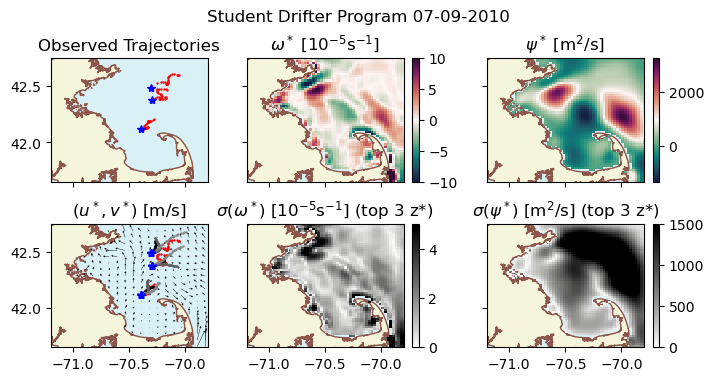

In [19]:
# Calculate standard deviation for psi
psi_std = np.std(np.array(psi_top), axis=0)
w_std = np.std(np.array(w_top), axis=0)

fig, axes = plt.subplots(2, 3, figsize=(7, 3.7), constrained_layout=True, sharex=True, sharey=True)

for ax in axes.flat:
    ax.set_facecolor(np.array([218, 240, 247])/255)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    mass.plot(ax=ax, color='beige', edgecolor='tab:brown')
    ax.set_aspect('equal', adjustable='box')

plt.sca(axes[0, 0])
plot_trajectories_lines(trajectories, color='red', label='Observed', start_label=False)
plt.title('Observed Trajectories')

# Quiver plot of mean (u, v)
axes[1, 0].quiver(grid_x[::3, ::3], grid_y[::3, ::3], u_opt[::3, ::3], v_opt[::3, ::3], color='k', headwidth=5)
plt.sca(axes[1, 0])
plot_trajectories_lines(trajectories, color='red', label='Observed', start_label=False)
for j, traj in enumerate(traj_top):
    if j == 0:
        plot_trajectories_lines(traj, color='k', label='Optimized', start_label=False)
    else:
        plot_trajectories_lines(traj, color=str(0.2 + 0.16 * j), start_label=False)
# plt.legend()
axes[1, 0].plot([], [], color='red', label='Observed')
axes[1, 0].plot([], [], color='k', label='Optimized')
# axes[0].legend(loc='lower left', fontsize=8)
axes[1, 0].set_title('$(u^*, v^*)$ [m/s]')

# omega_opt plot
c1 = axes[0, 1].pcolormesh(grid_x, grid_y, w_opt, cmap=cmocean.cm.curl, vmin=-10, vmax=10)
axes[0, 1].set_title('$\omega^*$ [10$^{-5}$s$^{-1}$]')
plt.colorbar(c1, ax=axes[0,1])

c2 = axes[0, 2].pcolormesh(grid_x, grid_y, psi_opt, cmap=cmocean.cm.curl)
axes[0, 2].set_title('$\psi^*$ [m$^2$/s]')
plt.colorbar(c2, ax=axes[0,2])

c3 = axes[1, 1].pcolormesh(grid_x, grid_y, w_std, cmap=cmocean.cm.gray_r, vmin=0, vmax=5)
axes[1, 1].set_title('$\sigma(\omega^*)$ [10$^{-5}$s$^{-1}$] ' + f'(top {k} z*)')
plt.colorbar(c3, ax=axes[1, 1])

c4 = axes[1, 2].pcolormesh(grid_x, grid_y, psi_std, cmap=cmocean.cm.gray_r, vmin=0, vmax=1500)
axes[1, 2].set_title('$\sigma(\psi^*)$ [m$^2$/s]' + f' (top {k} z*)')
plt.colorbar(c4, ax=axes[1, 2])

plt.suptitle(f'Student Drifter Program {start_time.strftime("%m-%d-%Y")}')
plt.savefig(f'{project_root}/figures/fvcom/bo/fvcom_optimization_real_{latent_dim}_{date_save}.png', dpi=300, bbox_inches='tight')
plt.show()


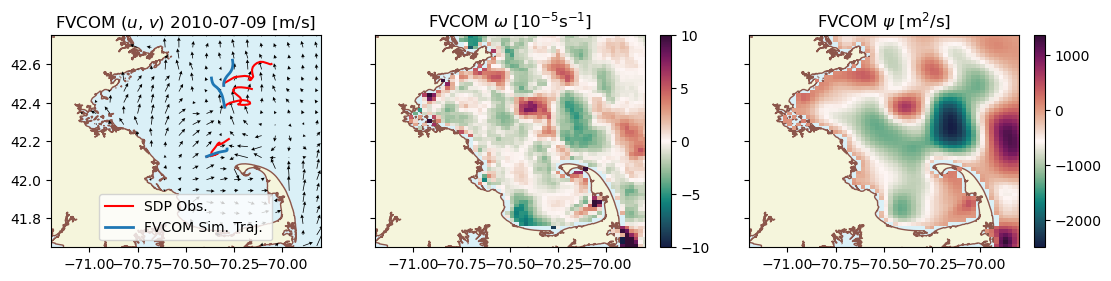

In [20]:
u_plot, v_plot = u[tstep, :, :], v[tstep, :, :]
omega_plot = vort_FVCOM(u_plot, v_plot, grid_x_m, grid_y_m)
psi_plot = streamfunction_FVCOM(omega_plot, grid_x_m, grid_y_m)

omega_plot = omega_plot*1e5

# Generate trajectories from u and v at the same initial locations as observed
sim_trajectories = {}
n_steps = max([len(traj) for traj in trajectories.values()])
for i, traj in trajectories.items():
    lon_lat_start = traj[0]
    start_x_m, start_y_m = sp_proj('forward', lon_lat_start[0], lon_lat_start[1], 'm')
    simulated_traj_m = generate_trajectory(u_fill[tstep, :, :], v_fill[tstep, :, :], grid_x_m, grid_y_m, start_x_m, start_y_m, dts[i])
    simulated_traj = np.array(sp_proj('inverse', simulated_traj_m[:,0], simulated_traj_m[:,1], 'm')).T
    sim_trajectories[i] = simulated_traj

# Plot observed and simulated trajectories
fig, axs = plt.subplots(1, 3, figsize=(11, 2.7), constrained_layout=True, sharex=True, sharey=True)
for ax in axs:
    ax.set_facecolor(np.array([218, 240, 247])/255)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    mass.plot(ax=ax, color='beige', edgecolor='tab:brown')
    ax.set_aspect('equal', adjustable='box')


axs[0].set_title(f'FVCOM ($u$, $v$) {date_print} [m/s]')
for i in trajectories:
    if i == 0:
        axs[0].plot(trajectories[i][:,0], trajectories[i][:,1], label=f'SDP Obs.', color='red')
        axs[0].plot(sim_trajectories[i][:,0], sim_trajectories[i][:,1], label=f'FVCOM Sim. Traj. ', color='tab:blue', linewidth=2)
    else:
        axs[0].plot(trajectories[i][:,0], trajectories[i][:,1], color='red')
        axs[0].plot(sim_trajectories[i][:,0], sim_trajectories[i][:,1], color='tab:blue', linewidth=2)

axs[0].quiver(grid_x[::3, ::3], grid_y[::3, ::3], u[tstep, ::3, ::3], v[tstep, ::3, ::3], color='k', headwidth=5)

axs[0].legend(loc='lower center')

axs[1].set_title('FVCOM $\omega$ [10$^{-5}$s$^{-1}$]')
vort_c = axs[1].pcolormesh(grid_x, grid_y, omega_plot, cmap=cmocean.cm.curl, vmin=-10, vmax=10)
fig.colorbar(vort_c, ax=axs[1])

axs[2].set_title('FVCOM $\psi$ [m$^2$/s]')
psi_c = axs[2].pcolormesh(grid_x, grid_y, psi_plot, cmap=cmocean.cm.curl)
fig.colorbar(psi_c, ax=axs[2])



plt.show()

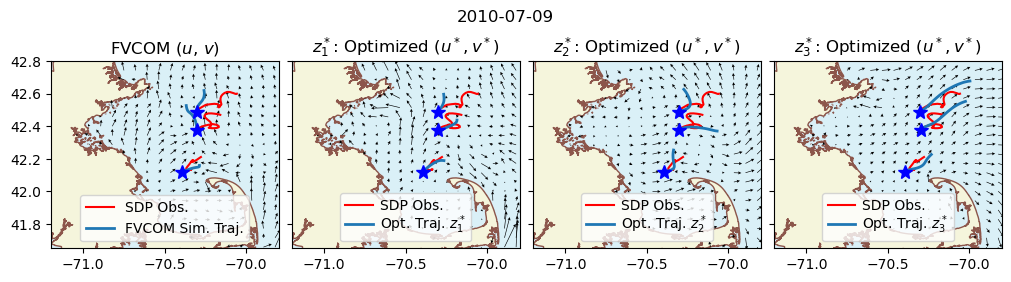

In [21]:
fig, axes = plt.subplots(1, 1+len(traj_top), figsize=(10, 2.75), constrained_layout=True, sharex=True, sharey=True)

# Top subplot: Quiver plot of mean (u, v)
ax = axes[0]
ax.set_facecolor(np.array([218, 240, 247])/255)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax+0.05)
mass.plot(ax=ax, color='beige', edgecolor='tab:brown')
ax.set_aspect('equal', adjustable='box')
ax.set_title(f'FVCOM ($u$, $v$)')
for i in trajectories:
    if i == 0:
        ax.plot(trajectories[i][:,0], trajectories[i][:,1], label=f'SDP Obs.', color='red')
        ax.plot(sim_trajectories[i][:,0], sim_trajectories[i][:,1], label=f'FVCOM Sim. Traj.', color='tab:blue', linewidth=2)
    else:
        ax.plot(trajectories[i][:,0], trajectories[i][:,1], color='red')
        ax.plot(sim_trajectories[i][:,0], sim_trajectories[i][:,1], color='tab:blue', linewidth=2)
    ax.plot(traj_top[traj_i][i][0,0], traj_top[traj_i][i][0,1], marker='*', color='blue', markersize=10, linestyle='None')
ax.quiver(grid_x[::3, ::3], grid_y[::3, ::3], u[tstep, ::3, ::3], v[tstep, ::3, ::3], color='k', headwidth=5)
ax.legend(loc='lower center')

for traj_i in range(len(traj_top)):
    ax = axes[traj_i + 1]
    ax.set_facecolor(np.array([218, 240, 247])/255)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax+0.05)
    mass.plot(ax=ax, color='beige', edgecolor='tab:brown')
    ax.set_aspect('equal', adjustable='box')
    ax.quiver(grid_x[::3, ::3], grid_y[::3, ::3], u_top[traj_i][::3, ::3], v_top[traj_i][::3, ::3], color='k', headwidth=5)
    for i in trajectories:
        if i == 0:
            ax.plot(trajectories[i][:,0], trajectories[i][:,1], label=f'SDP Obs.', color='red')
            ax.plot(traj_top[traj_i][i][:,0], traj_top[traj_i][i][:,1], label=f'Opt. Traj. $z^*_{traj_i + 1}$', color='tab:blue', linewidth=2)
        else:
            ax.plot(trajectories[i][:,0], trajectories[i][:,1], color='red')
            ax.plot(traj_top[traj_i][i][:,0], traj_top[traj_i][i][:,1], color='tab:blue', linewidth=2)
        ax.plot(traj_top[traj_i][i][0,0], traj_top[traj_i][i][0,1], marker='*', color='blue', markersize=10, linestyle='None')
    # ax.set_title(f'$z^*_{traj_i + 1}$: Optimized $(u^*, v^*)$\nCost function = {costs_sorted[traj_i]:.2f}')
    ax.set_title(f'$z^*_{traj_i + 1}$: Optimized $(u^*, v^*)$')
    # Reduce spacing between legend lines
    leg = ax.legend(loc='lower center', handletextpad=0.5, labelspacing=0.01, frameon=True)
    

plt.suptitle(date_print)
plt.savefig(f'{project_root}/figures/{project}/bo/fvcom_comparison_optimized_trajectories_{latent_dim}_{date_save}_real.png', dpi=300, bbox_inches='tight')